In [8]:
import matplotlib.pyplot as plt

%matplotlib inline

import pandas as pd
import torch as th
import numpy as np

# Dataset

In [9]:
batch_size = 128
hist_win = 7
pred_win = 1

In [61]:
def load_df(ticker):
  df = pd.read_csv(f'~/data/stock/kaggle/full_history/{ticker}.csv')
  # reverse so oldest is first
  df = df.iloc[::-1].reset_index(drop=True)
  return df

df = load_df('GOOG')
df.head(10)

,date,volume,open,high,low,close,adjclose
0,2004-08-19,44871300,49.813286,51.835709,47.800831,49.982655,49.982655
1,2004-08-20,22942800,50.316402,54.336334,50.062355,53.952770,53.952770
2,2004-08-23,18342800,55.168217,56.528118,54.321388,54.495735,54.495735
3,2004-08-24,15319700,55.412300,55.591629,51.591621,52.239193,52.239193
4,2004-08-25,9232100,52.284027,53.798351,51.746044,52.802086,52.802086
5,2004-08-26,7128600,52.279045,53.773445,52.134586,53.753517,53.753517
6,2004-08-27,6241200,53.848164,54.107193,52.647663,52.876804,52.876804
7,2004-08-30,5221400,52.443428,52.548038,50.814533,50.814533,50.814533
8,2004-08-31,4941200,50.958992,51.661362,50.889256,50.993862,50.993862
9,2004-09-01,9181600,51.158245,51.292744,49.648903,49.937820,49.937820


In [62]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

# Caveats
#   - looks at only 1 column
class StockSeqDataset(Dataset):
    def __init__(self, df, column='adjclose', hist_win=hist_win, pred_win=pred_win):
        self.df = df
        self.col = column
        self.hist_win = hist_win
        self.pred_win = pred_win
    
    def __getitem__(self, index):
        assert 0 <= index < len(self)
        x_end = index + self.hist_win
        x = df.iloc[index:x_end][self.col]
        y = df.iloc[x_end:x_end+self.pred_win][self.col]
        return (th.from_numpy(np.array(x, dtype=np.float32)),
                th.from_numpy(np.array(y, dtype=np.float32)))
    
    def __len__(self):
        return len(self.df) - self.hist_win - self.pred_win + 1

ds = StockSeqDataset(df)

dl = DataLoader(dataset=ds, batch_size=batch_size, shuffle=True)

In [63]:
ds[0]

(tensor([49.9827, 53.9528, 54.4957, 52.2392, 52.8021, 53.7535, 52.8768]),
 tensor([50.8145]))

In [64]:
for x, y in dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([128, 7])
torch.Size([128, 1])


# Model

In [65]:
model = th.nn.Sequential(
    th.nn.Linear(hist_win, pred_win),
    #th.nn.ReLU(),
    #th.nn.Linear(100, pred_win),
)

loss_fn = th.nn.MSELoss()

learning_rate = 0.005
optimizer = th.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.5))
lr_schedule = th.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)

for epoch in range(20):
    loss_avg = 0
    for x, y in dl:
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        loss_avg += loss.item()
        #print(loss.item())
    lr_schedule.step()
    print(f'{lr_schedule.get_lr()[0]:.5f} {loss_avg / len(dl)}')

/home/z/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:425: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


0.00405 146583.0071105957
0.00365 441.78283882141113
0.00328 411.12889766693115
0.00295 416.3936309814453
0.00266 390.20105743408203
0.00239 379.54114818573
0.00215 386.71445083618164
0.00194 378.4715871810913
0.00174 368.63591480255127
0.00157 364.02690076828003
0.00141 381.71972703933716
0.00127 363.8498582839966
0.00114 354.5209937095642
0.00103 349.202271938324
0.00093 349.38642263412476
0.00083 341.30994510650635
0.00075 334.5336947441101
0.00068 335.6001901626587
0.00061 332.2267804145813
0.00055 329.59850668907166


In [66]:
lr_schedule.get_lr()

[0.0005470949456575623]

In [67]:
y.t()

tensor([[ 807.6700, 1431.9700,   89.6838,  566.9549,  193.0265,  227.6567,
          261.5696,  290.4115,  438.2623, 1152.8400,  139.2680,  245.5795,
          289.3305,   93.6440,  541.6529,  338.0479, 1137.5100,  539.7900,
          248.9270,  599.0994,  556.5739]])

In [68]:
model(x).t()

tensor([[ 798.3361, 1450.1566,   90.4401,  571.4382,  200.5381,  239.7377,
          273.8939,  289.6543,  433.2547, 1126.9230,  142.5654,  249.4628,
          286.1869,   96.9705,  561.4970,  338.4532, 1122.1849,  540.5750,
          241.7103,  607.7022,  556.7209]], grad_fn=<TBackward>)

# Validation

In [115]:
def validate(model, ticker):
    df = load_df(ticker)
    ds = StockSeqDataset(df)
    dl = DataLoader(dataset=ds, batch_size=batch_size, shuffle=False)
    loss_avg = 0
    actual = []
    predicted = []
    for x, y in dl:
        actual.append(y.detach().cpu().numpy())
        optimizer.zero_grad()
        y_pred = model(x)
        predicted.append(y_pred.detach().cpu().numpy())
        loss = loss_fn(y_pred, y)
        loss_avg += loss.item()
    actual = np.concatenate(actual)
    predicted = np.concatenate(predicted)
    loss_avg /= len(dl)
    return actual, predicted, loss_avg

class MeanModel(th.nn.Module):
    def forward(self, x):
        return x.mean(dim=-1).unsqueeze(axis=1)

def plot(actual, predicted):
    plt.figure(figsize=(10, 8))
    plt.plot(np.squeeze(actual)[::-1])
    plt.plot(np.squeeze(predicted)[::-1])
    plt.legend(('actual', 'predicted'))

In [70]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0596,  0.0223,  0.3569,  0.2782, -0.1029,  0.4749, -0.0865]],
        requires_grad=True),
 Parameter containing:
 tensor([0.4319], requires_grad=True)]

In [71]:
actual, pred, loss_avg = validate(model, 'FB')

(2037, 1)
Avg loss: 73.2558925151825


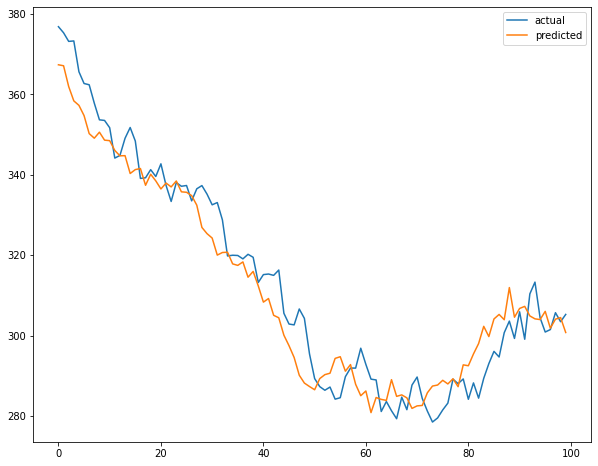

In [72]:
plot(actual[-100:], pred[-100:])

In [73]:
# Baseline
actual, pred, loss_avg = validate(MeanModel(), 'FB')

(2037, 1)
Avg loss: 64.66447865962982


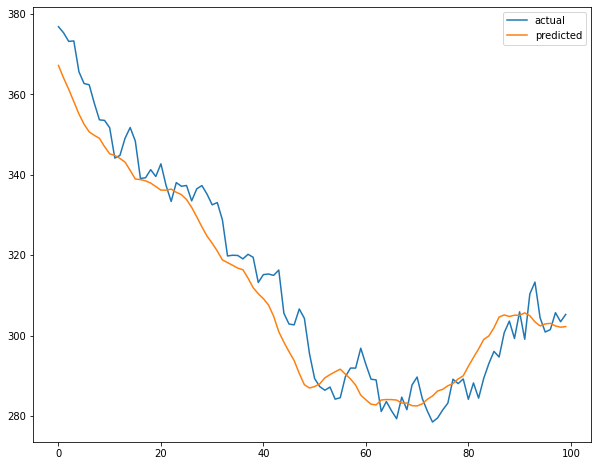

In [74]:
plot(actual[-100:], pred[-100:])

# Strategy

In [116]:
class SimpleStrategy:
  """Simple strategy

  If day's predicted change is positive, hold through day.
  If day's predicted change is negative, skip the day.
  """
  def __init__(self, model, ticker):
    self.model = model
    self.ticker = ticker

  def compute_hold(self):
    actual, pred, _ = validate(self.model, self.ticker)
    actual, pred = actual.squeeze(), pred.squeeze()
    assert len(actual) == len(pred)
    hold = pred[1:] > pred[:-1]
    return pd.DataFrame.from_dict({
        'actual': actual[1:],
        'pred': pred[1:],
        'hold': hold,
    })

def compute_returns(df):
  df = df.copy()
  df.loc[:, 'roi_actual'] = df.actual / df.actual.shift(1)
  df.loc[:, 'roi_pred'] = df.pred / df.pred.shift(1)
  return df

def total_return(df, query=None):
  if query:
    df = df.query(query)
  roi_actual = df.roi_actual.product()
  roi_pred = df.roi_pred.product()
  print(f'{query}; Actual: {roi_actual:0.4f}; predicted: {roi_pred:0.4f}')

def model_roi(model, ticker):
  strat = SimpleStrategy(model, ticker)
  df_hold = strat.compute_hold()
  df_roi = compute_returns(df_hold)
  total_return(df_roi)
  total_return(df_roi, 'hold == True')
  total_return(df_roi, 'hold == False')


In [117]:
model_roi(model, 'FB')

None; Actual: 7.3898; predicted: 6.8817
hold == True; Actual: 3.5620; predicted: 96785.3438
hold == False; Actual: 2.0747; predicted: 0.0001


In [118]:
model_roi(model, 'GOOG')

None; Actual: 28.7230; predicted: 26.5218
hold == True; Actual: 4.3168; predicted: 254105568.0000
hold == False; Actual: 6.6537; predicted: 0.0000


In [119]:
model_roi(MeanModel(), 'FB')

None; Actual: 7.3898; predicted: 6.9293
hold == True; Actual: 4.5332; predicted: 1503.1960
hold == False; Actual: 1.6302; predicted: 0.0046


In [120]:
model_roi(MeanModel(), 'GOOG')

None; Actual: 28.7230; predicted: 26.8085
hold == True; Actual: 9.9587; predicted: 163240.8750
hold == False; Actual: 2.8842; predicted: 0.0002
